<a href="https://colab.research.google.com/github/liady/dl-ydata/blob/master/Liad_dl_0001_cuda_collab_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning in Medical AI 2018/2019 using PyTorch & Google Collab.


<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/drive/1JEIeD_445sFvcjSrITB5Z_oW8VHRS_kA">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/deeponcology/PyTorchMedicalAI/blob/master/shlomo_dl_0001_cuda_collab_pytorch.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

<img src="https://github.com/deeponcology/PyTorchMedicalAI/raw/master/assets/tumor_visdom.jpg" align="center" width=30%>

### Author: 
***Shlomo Kashani***, Head of AI at www.DeepOncology.AI, shlomo@deeponcology.ai 

<img src="https://github.com/deeponcology/PyTorchMedicalAI/raw/master/assets/line-up-small.png" align="center" width=30%>


### Synopsys:
This is the hands-on deep learning tutorial series for the 2018/2019 Medical AI course. The series will guide you through the most basic building blocks such as installing CUDA to training advanced CNN's such as SeNet. 

### DataSets:
We foster the use of Medical Data Sets (https://grand-challenge.org/All_Challenges/) and predominantly those available (but not only) via Kaggle.

### About PyTorch:

PyTorch is an open source library for numerical computation using  computation graphs. Nodes in the graph represent mathematical operations, while the graph edges represent the multidimensional data arrays (tensors) communicated between them. 


Similar to python programming, we can add and execute a node to the computation graph immediately. This property makes it easy to debug the code and inspect the values in the network.

### The other Notebooks in this series: 
If you are familiar with these topics, feel free to jump to other modules.



# Collab notebook: 001 using C CUDA  code from Python

In [0]:
#@title Sample Header for Jupyter HW submission
#@markdown Forms support many types of fields.

your_kaggle_name = 'DeepOncology___'  #@param {type: "string"}
select_dataset = "seeds" #@param ["seeds", "dsb2018", "dsb2019"] {allow-input: true}
kaggle_acc_score = 77  # @param {type: "slider", min: 0, max: 100}
kaggle_log_loss_score = 75  # @param {type: "slider", min: 0, max: 100}
kaggle_IOU_score = 75  # @param {type: "slider", min: 0, max: 100}
date = '2010-11-05'  #@param {type: "date"}
pick_me = "monday"  #@param ['monday', 'tuesday', 'wednesday', 'thursday']

#@markdown ---


In [0]:
%reset -f

In [0]:
# Do we have cuda?!
!which nvcc
!nvcc --version

/usr/local/cuda/bin/nvcc
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Tue_Jun_12_23:07:04_CDT_2018
Cuda compilation tools, release 9.2, V9.2.148


In [0]:
# Let's check if a GPU accelerator card is attached in our machine:
!ls -l /dev/nv*

crw-rw-rw- 1 root root 195,   0 Nov 28 13:44 /dev/nvidia0
crw-rw-rw- 1 root root 195, 255 Nov 28 13:44 /dev/nvidiactl
crw-rw-rw- 1 root root 248,   0 Nov 28 13:44 /dev/nvidia-uvm
crw-rw-rw- 1 root root 248,   1 Nov 28 13:44 /dev/nvidia-uvm-tools


In [0]:
# This works too, GPU count and name
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-ec13b826-a61a-9b19-c79f-20280de430df)


### Use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'

In [0]:
! nvidia-smi

Wed Nov 28 13:52:58 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [0]:
#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

Thread(s) per core:  2


In [0]:
#memory that we can use
!cat /proc/meminfo | grep 'MemAvailable'

MemAvailable:   12659816 kB


In [0]:
#hard disk that we can use
!df -h / | awk '{print $4}'

Avail
333G


In [0]:
import os
os.environ['PATH'] += ':/usr/local/cuda/bin'

In [0]:
# This magic will create a new CU file
# To write a CUDA C program, we need to:

#Create a source code fi le with the special fi le name extension of .cu.
#Compile the program using the CUDA nvcc compiler.
#Run the executable file from the command line, which contains the kernel code executable on the GPU.

%%file version.cu
#include <thrust/version.h>
#include <iostream>

int main(void)
{
  int major = THRUST_MAJOR_VERSION;
  int minor = THRUST_MINOR_VERSION;

  std::cout << "Thrust v" << major << "." << minor << std::endl;

  return 0;
}

Writing version.cu


In [0]:
# nvcc is the CUDA compiler 
!nvcc version.cu -o version
!./version

Thrust v1.9


###  Memory footprint support libraries/code

In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /root/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /root/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize
Gen RAM Free: 13.0 GB  I Proc size: 140.4 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


# Collab notebook: 002 PyTorch DataLoaders

We are going to create a data loader for a neutral network to classify images.  
We are **NOT** going to run the neural network; just to load data. 

In [0]:
import sys
sys.version


'3.6.7 (default, Oct 22 2018, 11:32:17) \n[GCC 8.2.0]'

In [0]:
import torch

ModuleNotFoundError: ignored

## Great, so we need to install PyTorch ... 

In [0]:
# !pip3 install torch==0.4
# !pip3 install torchvision

!pip3 install 'torch==0.4.0'
!pip3 install 'torchvision==0.2.1'
!pip3 install --no-cache-dir -I 'pillow==5.1.0'

# Restart Kernel
# This workaround is needed to properly upgrade PIL on Google Colab.
import os
os._exit(00)

    100% |████████████████████████████████| 484.0MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5b39c000 @  0x7f08078ff2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.4MB/s 
    100% |████████████████████████████████| 2.0MB 14.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 2.0MB 4.4MB/s 


## Import PyTorch once again

In [0]:
import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random 


## Let's print the versions

In [0]:
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

use_cuda = torch.cuda.is_available()
# use_cuda = False

print("USE CUDA=" + str (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

__Python VERSION: 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
__pyTorch VERSION: 0.4.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Tue_Jun_12_23:07:04_CDT_2018
Cuda compilation tools, release 9.2, V9.2.148
__CUDNN VERSION: 7102
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
USE CUDA=True


## Fixing the Random Seed

In [0]:
manualSeed = 2222
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if manualSeed is None:
        manualSeed = 999
fixSeed(manualSeed)

## The DataSet class ... PyTorch Datasets

To create a dataset, we subclass Dataset and define a constructor, a __len__ method, and a __getitem__ method. Here is full example:

In [0]:
import os, sys, pdb, shutil, time, random
import argparse
import torch
import torch.backends.cudnn as cudnn
import torchvision.datasets as dset
import torchvision.transforms as transforms
# from utils import AverageMeter, RecorderMeter, time_string, convert_secs2time
# from tensorboard_logger import configure, log_value
from tqdm import tqdm
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random
import sys
from glob import glob
import fnmatch

class GenericDataset(Dataset):
  def __init__(self, labels, root_dir, subset=False, transform=None):
    self.labels = labels
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    img_name = self.labels.iloc[idx, 0]  # file name
    fullname = join(self.root_dir, img_name)
    image = Image.open(fullname).convert('RGB')
    labels = self.labels.iloc[idx, 2]  # category_id
    #         print (labels)
    if self.transform:
      image = self.transform(image)
    return image, labels

  @staticmethod
  def find_classes(fullDir):
    classes = [d for d in os.listdir(fullDir) if os.path.isdir(os.path.join(fullDir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    num_to_class = dict(zip(range(len(classes)), classes))

    train = []
    for index, label in enumerate(classes):
      path = fullDir + label + '/'
      for file in listdir(path):
        train.append(['{}/{}'.format(label, file), label, index])

    df = pd.DataFrame(train, columns=['file', 'category', 'category_id', ])

    return classes, class_to_idx, num_to_class, df

## Download the data

### Kaggle 162 H&E
This dataset consists of 5547 breast histology images of size 50 x 50 x 3, curated from Andrew Janowczyk website and used for a data science tutorial at Epidemium. The goal is to classify cancerous images (IDC : invasive ductal carcinoma) vs non-IDC images.

### Download: 
https://www.kaggle.com/simjeg/lymphoma-subtype-classification-fl-vs-cll or http://andrewjanowczyk.com/wp-static/IDC_regular_ps50_idx5.zip



### Download:
https://www.kaggle.com/c/plant-seedlings-classification
kaggle competitions download -c plant-seedlings-classification


data_dir= '/home/data/bone/train/'
    data_dir= '/home/data/bone/train/

    ├── valid
    │   └── Type_1
        ├── Type_2
        └── Type_3
    └── train
        ├── Type_1
        ├── Type_2
        └── Type_3

In [0]:
# kaggle competitions download -c plant-seedlings-classification
!wget http://andrewjanowczyk.com/wp-static/IDC_regular_ps50_idx5.zip


--2018-11-18 08:53:52--  http://andrewjanowczyk.com/wp-static/IDC_regular_ps50_idx5.zip
Resolving andrewjanowczyk.com (andrewjanowczyk.com)... 129.22.136.73
Connecting to andrewjanowczyk.com (andrewjanowczyk.com)|129.22.136.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1644892042 (1.5G) [application/zip]
Saving to: ‘IDC_regular_ps50_idx5.zip’

IDC_regular_ps50_id 100%[===================>]   1.53G  2.63MB/s    in 12m 55s 

2018-11-18 09:06:47 (2.02 MB/s) - ‘IDC_regular_ps50_idx5.zip’ saved [1644892042/1644892042]



## Export your Kaggle API Key

In [0]:
!mkdir -p ~/.kaggle
# ~/.kaggle/kaggle.json
  # {"username":"solomonk","key":"af21d853c5e242e7d4c3e0e6a588309b"}
  # kaggle competitions download -c plant-seedlings-classification

In [0]:
%%file ~/.kaggle/kaggle.json
  
{"username":"solomonk","key":"af21d853c5e242e7d4c3e0e6a588309b"}
  
  

Writing /root/.kaggle/kaggle.json


In [8]:
# from google.colab import drive
# drive.mount('/content/gdrive')
!pip install kaggle --upgrade
!kaggle competitions download -c plant-seedlings-classification

    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 245kB 7.3MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/5a/2d/0c/9fc539e558586b9ed9127916a7f4e620163c24cc97460b1188
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify
  0% 0.00/5.13k [00:00<?, ?B/s]
100% 5.13k/5.13k [00:00<00:00, 3.48MB/s]
 99% 85.0M/86.0M [00:01<00:00, 55.5MB/s]
100% 86.0M/86.0M [00:01<00:00, 82.2MB/s]
100% 1.60G/1.60G [00:12<00:00, 167MB/s]
100% 1.60G/1.60G [00:12<00:00, 135MB/s]


In [9]:
! ls -la

total 3373256
drwxr-xr-x 1 root root       4096 Dec  6 11:54 .
drwxr-xr-x 1 root root       4096 Dec  6 11:35 ..
drwxr-xr-x 1 root root       4096 Dec  4 21:01 .config
-rw-r--r-- 1 root root 1644892042 Jun 26  2017 IDC_regular_ps50_idx5.zip
drwxr-xr-x 2 root root       4096 Dec  4 21:01 sample_data
-rw-r--r-- 1 root root       5251 Dec  6 11:54 sample_submission.csv.zip
-rw-r--r-- 1 root root   90141460 Dec  6 11:54 test.zip
-rw-r--r-- 1 root root 1718530069 Dec  6 11:54 train.zip
-rwxr-xr-x 1 root root     601600 Dec  6 11:36 version
-rw-r--r-- 1 root root        218 Dec  6 11:36 version.cu


In [10]:
!mkdir seeds
!mv train.zip seeds/train.zip
!unzip seeds/train.zip 

Archive:  seeds/train.zip
   creating: train/
   creating: train/Fat Hen/
  inflating: train/Fat Hen/5bdfa3a44.png  
  inflating: train/Fat Hen/a86b9c0cd.png  
  inflating: train/Fat Hen/f3f6559bf.png  
  inflating: train/Fat Hen/946b48f62.png  
  inflating: train/Fat Hen/4d7fd4020.png  
  inflating: train/Fat Hen/2509e5bc5.png  
  inflating: train/Fat Hen/e2462573b.png  
  inflating: train/Fat Hen/7e98e4aa6.png  
  inflating: train/Fat Hen/075cb6666.png  
  inflating: train/Fat Hen/b43d0a350.png  
  inflating: train/Fat Hen/afac20b21.png  
  inflating: train/Fat Hen/4d2efbb45.png  
  inflating: train/Fat Hen/f0923dcd6.png  
  inflating: train/Fat Hen/180f41d53.png  
  inflating: train/Fat Hen/bfdeafadd.png  
  inflating: train/Fat Hen/ac6625b0f.png  
  inflating: train/Fat Hen/ba5c8f87f.png  
  inflating: train/Fat Hen/e7d278e0e.png  
  inflating: train/Fat Hen/efaab2370.png  
  inflating: train/Fat Hen/9d4722e74.png  
  inflating: train/Fat Hen/4e2f543a2.png  
  inflating: train/Fat 

In [11]:
! ls seeds

train.zip


In [12]:
!ls train

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [0]:
import os
from glob import glob
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

dataset='train/' # 
data_dir= './' +  dataset

## Print single image

Number of images: 4750
./train/Scentless Mayweed/e61b6ff29.png
./train/Scentless Mayweed/2f998af91.png
./train/Scentless Mayweed/df6448756.png
./train/Scentless Mayweed/b15980d50.png
./train/Scentless Mayweed/7d3b1def6.png


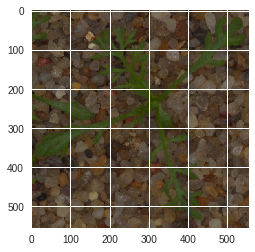

In [14]:
# !pip install --no-cache-dir -I pillow
# !pip install Pillow==4.0.0
# !pip install PIL
# !pip install image

import matplotlib.pyplot as plt
%matplotlib inline

# import matplotlib as mpl
# mpl.rcParams['axes.grid'] = False
# mpl.rcParams['image.interpolation'] = 'nearest'
# mpl.rcParams['figure.figsize'] = 15, 25

imageList = glob(data_dir + '/**/*.png', recursive=True)
print ( "Number of images: {}". format (len (imageList)))
for img in imageList[0:5]:
    print(img)
    
%matplotlib inline
pil_im = Image.open(imageList[0], 'r')
imshow(np.asarray(pil_im))

## Print a grid of images

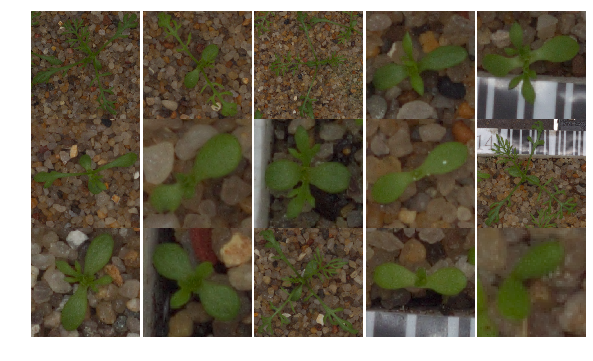

In [15]:
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in imageList[:15]:
    pil_im = Image.open(l, 'r')        
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(np.asarray(pil_im)); 
    plt.axis('off')
    i_ += 1

## Now we will use the PyTorch DataSet, NOT simple image read

In [16]:
classes, class_to_idx, num_to_class, df =GenericDataset.find_classes(data_dir )

print (classes)
print (class_to_idx)
print (num_to_class)
df.head(5)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
{0: 'Black-grass', 1: 'Charlock', 2: 'Cleavers', 3: 'Common Chickweed', 4: 'Common wheat', 5: 'Fat Hen', 6: 'Loose Silky-bent', 7: 'Maize', 8: 'Scentless Mayweed', 9: 'Shepherds Purse', 10: 'Small-flowered Cranesbill', 11: 'Sugar beet'}


,file,category,category_id
0,Black-grass/d112c9c28.png,Black-grass,0
1,Black-grass/2ee4dad8c.png,Black-grass,0
2,Black-grass/6afa7c717.png,Black-grass,0
3,Black-grass/da5082ce2.png,Black-grass,0
4,Black-grass/c3b38d028.png,Black-grass,0


## Target distribution : Train set

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


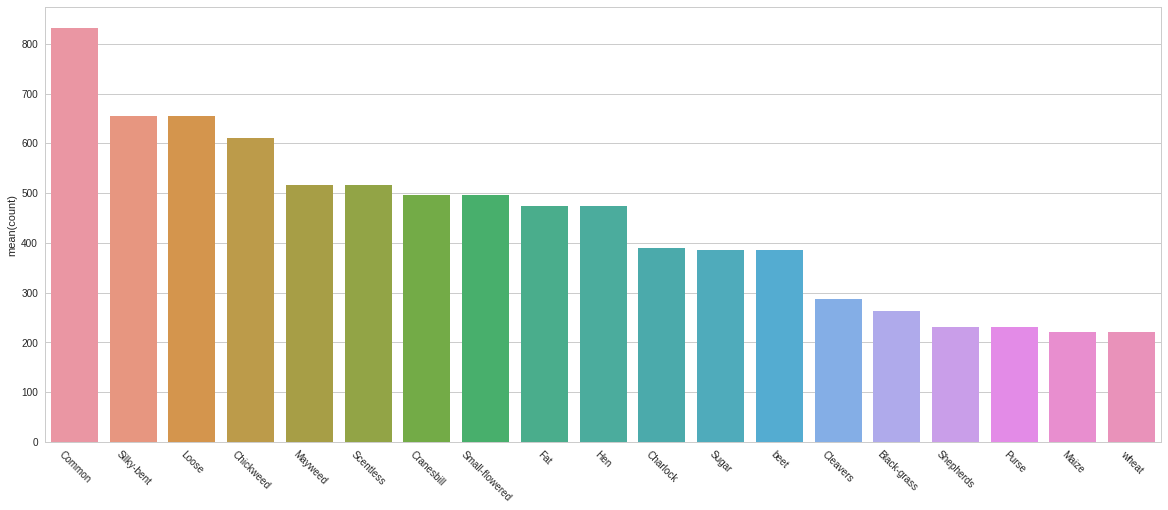

In [17]:
import seaborn as sns
sns.set(color_codes=True)
pal = sns.color_palette()
sns.set_style("whitegrid")

labels = df['category'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(20,8)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-45);

## Augmentation / Transformations

- The train dataset includes data augmentation techniques such as cropping to size 224 and horizontal flips.The train and validiation datasets are normalized with mean: [0.485, 0.456, 0.406], and standard deviation: [0.229, 0.224, 0.225]. 

- These values are the **means and standard deviations of the ImageNet images**. 

- We use these values because usually *pretrained* models are trained on ImageNet.



In [0]:
from __future__ import absolute_import

from torchvision.transforms import *

from PIL import Image, ImageDraw
import numpy as np
import torch

import torchvision
import random
from PIL import Image, ImageOps
import numpy as np
import numbers
import math
import torch
import torch
import random
import PIL.ImageEnhance as ie
import PIL.Image as im

# adapted from https://github.com/kuangliu/pytorch-retinanet/blob/master/transform.py
# https://github.com/mratsim/Amazon-Forest-Computer-Vision/blob/master/src/p_data_augmentation.py

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


### Data Augmenting using PyTorch is quite easy. 

- We can use the transforms provided in torchvision: torchvision.transforms.

- To compose more than a few transforms together, we use torchvision.transforms.Compose and provide the transforms as a list. 
- The transforms are applied following the list order.

#### Central note:
- For training a CNN, the transforms.ToTensor is used to convert the images to a PyTorch Tensor and transforms.Normalize to normalize the images according to the pre trained network that you will train. We are omitting these steps since we focus on augmenting images.


{'train': 4038, 'valid': 712}
6     556
3     517
8     447
5     416
10    410
1     339
11    315
2     246
0     228
9     195
7     188
4     181
Name: category_id, dtype: int64


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:563: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


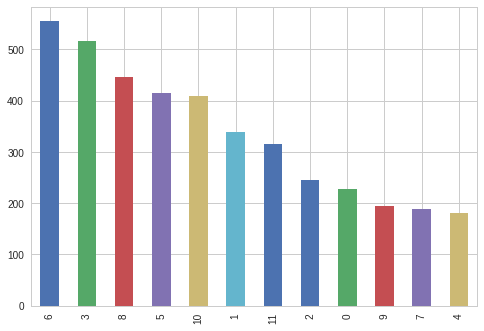

In [29]:
image_size = 224

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


train_trans = transforms.Compose([
    transforms.RandomSizedCrop(image_size),
    transforms.ToTensor(),
])

## Normalization only for validation and test
valid_trans = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
#     normalize_img
])

batch_size = 8
train_data = df.sample(frac=0.85)
valid_data = df[~df['file'].isin(train_data['file'])]

train_set = GenericDataset(train_data, data_dir, transform = train_trans)
valid_set = GenericDataset(valid_data, data_dir, transform = valid_trans)
        

t_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
v_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
# test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=sys.cpu_count -1)

dataset_sizes = {
    'train': len(t_loader.dataset), 
    'valid': len(v_loader.dataset)
}


print (dataset_sizes)
print (train_data["category_id"].value_counts())

train_data['category_id'].value_counts().plot(kind='bar')


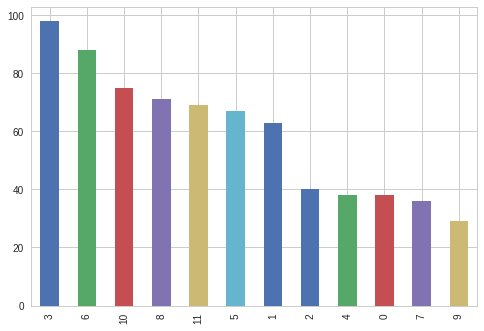

In [20]:
valid_data['category_id'].value_counts().plot(kind='bar')

## Test the data loader

i=0: 
i=1: 
i=2: 
i=3: 


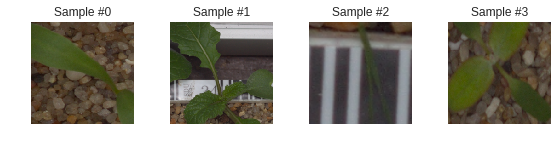

In [30]:
imagesToShow=4

def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    

if __name__ == '__main__':  
    for i, data in enumerate(t_loader, 0):
        print('i=%d: '%(i))            
        images, labels = data            
        num = len(images)

        ax = plt.subplot(1, imagesToShow, i + 1)
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')

        for n in range(num):
            image=images[n]
            label=labels[n]
            plt.imshow (flaotTensorToImage(image))

        if i==imagesToShow-1:
            break

## A simple Custom Data Augmentation

The augmentations available on PyTorch are  simple. What if we want to perform more interesting augmentations?

Let's use - https://github.com/zhunzhong07/Random-Erasing to achieve that.

In [0]:
from skimage import draw

class RandomErasing(object):
    def __init__(self, EPSILON = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0.4914, 0.4822, 0.4465]):
        self.EPSILON = EPSILON
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1
       
    def __call__(self, img):

        if random.uniform(0, 1) > self.EPSILON:
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]
       
            target_area = random.uniform(self.sl, self.sh) * area
            r = int(np.sqrt(target_area / np.pi))

            if r <= img.size()[2] and r <= img.size()[1]:
                x1 = random.randint(r, img.size()[1] - r)
                y1 = random.randint(r, img.size()[2] - r)
                cc,rr = draw.circle(x1, y1, r, shape = [img.size()[1], img.size()[2]])

                if img.size()[0] == 3:
                    img[0, cc, rr] = self.mean[0]
                    img[1, cc, rr] = self.mean[1]
                    img[2, cc, rr] = self.mean[2]
                else:
                    img[0, cc, rr] = self.mean[1]
                return img

        return img

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:563: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


{'train': 4038, 'valid': 712}
6     566
3     505
8     453
10    432
5     405
11    325
1     325
2     250
0     209
7     193
9     191
4     184
Name: category_id, dtype: int64
i=0: 
i=1: 
i=2: 
i=3: 


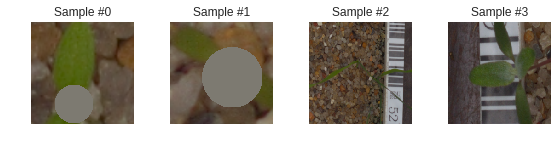

In [35]:
image_size = 224

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


train_trans = transforms.Compose([
    transforms.RandomSizedCrop(image_size),
#     PowerPIL(),
    transforms.ToTensor(),
#     normalize_img,
    RandomErasing()
])

## Normalization only for validation and test
valid_trans = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
#     normalize_img
])

batch_size = 8
train_data = df.sample(frac=0.85)
valid_data = df[~df['file'].isin(train_data['file'])]

train_set = GenericDataset(train_data, data_dir, transform = train_trans)
valid_set = GenericDataset(valid_data, data_dir, transform = valid_trans)
        

t_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
v_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
# test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

dataset_sizes = {
    'train': len(t_loader.dataset), 
    'valid': len(v_loader.dataset)
}


print (dataset_sizes)
print (train_data["category_id"].value_counts())


imagesToShow=4

def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    

if __name__ == '__main__':  
    for i, data in enumerate(t_loader, 0):
        print('i=%d: '%(i))            
        images, labels = data            
        num = len(images)

        ax = plt.subplot(1, imagesToShow, i + 1)
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')

        for n in range(num):
            image=images[n]
            label=labels[n]
            plt.imshow (flaotTensorToImage(image))

        if i==imagesToShow-1:
            break

# Collab notebook: 003 Install Tensorboard  to monitor PyTorch
- may be easier to use https://github.com/mixuala/colab_utils

In [0]:
# !apt-get install cuda-9-0

# !pip install tensorflow-gpu
# !pip install tensorboard 
# !pip install tensorboardx

# import tensorflow as tf # This is how we import tf

In [25]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = '../input/logs/Logs/' # Here you have to put your log directory
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
    

--2018-12-06 11:56:59--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.2.175.150, 52.86.186.182, 52.201.75.180, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.2.175.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  3.37MB/s    in 1.5s    

2018-12-06 11:57:02 (3.37 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://2337469a.ngrok.io
